# Getting Started with OpenPulse

Qiskit Pulse programs give you more control than `QuantumCircuit`. At this level, you can specify the exact time dynamics of the input signals across all input channels. Most quantum algorithm can be described with circuits alone using gate operations -- typically, it's when you want to apply error mitigation techniques or characterize a time-dependent quality of a quantum system that pulse-level control becomes useful.

On this page, we will discover how to build and execute a very basic Pulse program, which is called a schedule.

### Initialize

We import the `Schedule` class from the `qiskit.pulse` module. To start, we are going to initialize a  `Schedule` with the name `"getting_started"`.

In [1]:
from qiskit.pulse import Schedule

sched = Schedule(name='getting_started')

Easy! We have an empty schedule now.

### Build instructions

The next thing we will want to do is create some instructions to add to our schedule.

Perhaps the most central instruction for building schedules is the `SamplePulse`. It is a pulse signal specified as an array of time-ordered complex amplitudes, or _samples_. Each sample is played for one cycle, a timestep `dt`, determined by the backend. If we want to know the real-time dynamics of our program, we need to know the value of `dt`. For now, let's focus on how to build the instruction.

In [2]:
from qiskit.pulse import Waveform

my_pulse = Waveform([0.00043, 0.0007 , 0.00112, 0.00175, 0.00272, 0.00414, 0.00622,
                        0.00919, 0.01337, 0.01916, 0.02702, 0.03751, 0.05127, 0.06899,
                        0.09139, 0.1192 , 0.15306, 0.19348, 0.24079, 0.29502, 0.35587,
                        0.4226 , 0.49407, 0.56867, 0.64439, 0.71887, 0.78952, 0.85368,
                        0.90873, 0.95234, 0.98258, 0.99805, 0.99805, 0.98258, 0.95234,
                        0.90873, 0.85368, 0.78952, 0.71887, 0.64439, 0.56867, 0.49407,
                        0.4226 , 0.35587, 0.29502, 0.24079, 0.19348, 0.15306, 0.1192 ,
                        0.09139, 0.06899, 0.05127, 0.03751, 0.02702, 0.01916, 0.01337,
                        0.00919, 0.00622, 0.00414, 0.00272, 0.00175, 0.00112, 0.0007 ,
                        0.00043],
                       name="short_gaussian_pulse")

There are multiple ways to build pulses, which you can learn about on later pages. This time, we've simply passed the exact amplitudes of the pulse envelope we want to play as an array. The array above is a Gaussian function evaluated at 64 points, with an amplitude of 1 and a standard deviation of 8. The (zero-indexed) $i^{th}$ sample will play from time `i*dt` up to `(i + 1)*dt`, modulated by the qubit frequency. Think of this like an arbitrary waveform generator (AWG), playing the samples you give to the `SamplePulse`, mixed with a continuous sine wave generator outputting a tone at the qubit frequency.

The values above happen to be real, but they can also be complex. The amplitude norm of any pulse signal is arbitrarily limited to 1. Each backend system may also impose further constraints -- for instance, a minimum pulse size of 64. Learn more about getting information from the backend [here](5_gathering_system_information.ipynb).

### Schedule instructions

Next, we have to add an instruction to execute the pulse signal we just built. This means specifying not only the _time_ that the pulse should be played, but also _where_ it should be played. When we build circuits, we specify which qubit a gate operation should be applied to. In Pulse, every qubit has multiple _channels_.

We will _play_ our pulse on the _drive_ channel of qubit 0. The drive channel lets us enact single qubit operations.

In [3]:
from qiskit.pulse import Play, DriveChannel

qubit_idx = 0

sched = sched.insert(0, Play(my_pulse, DriveChannel(qubit_idx)))

Note that the pulse we defined operates on the `DriveChannel`, which in turn is initialized with the qubit index. We use `Schedule.insert` to play the pulse at timestep `t = 0`. 

Let's review what we've done, using `Schedule.draw`:

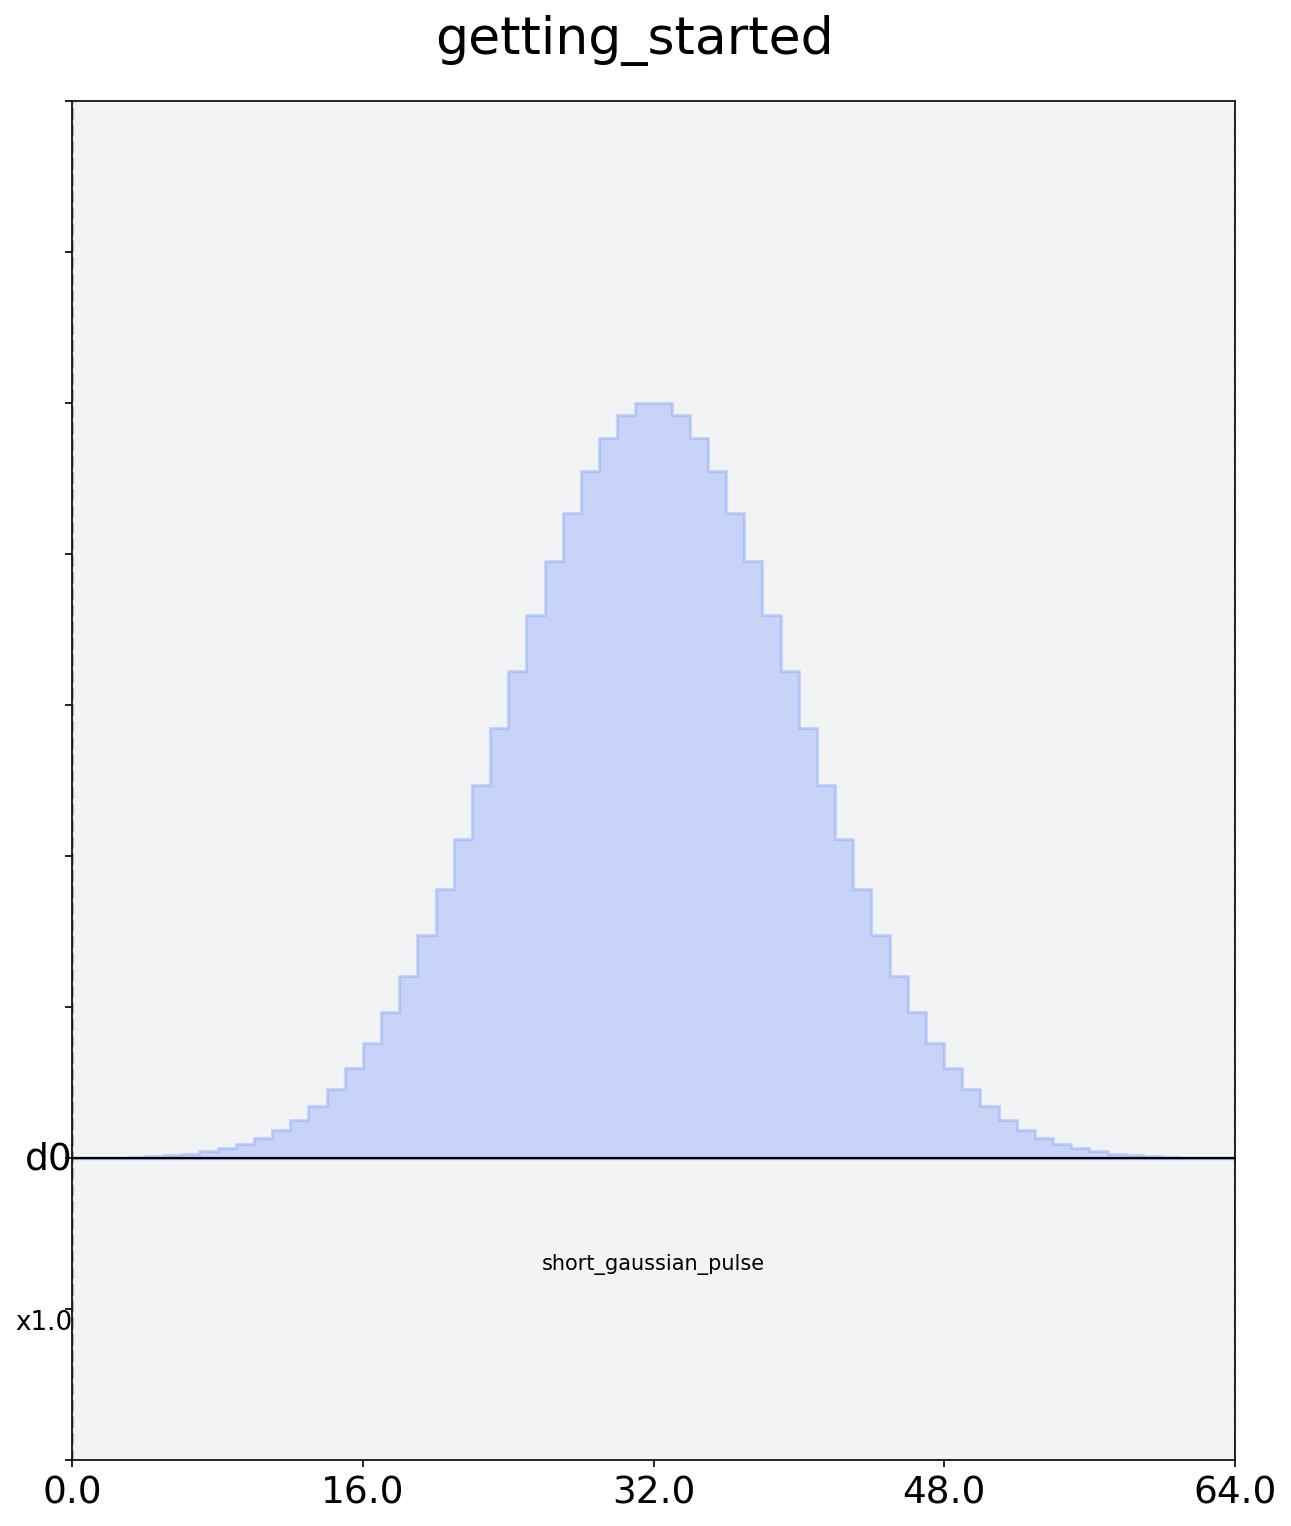

In [4]:
sched.draw(label=True)

The ways in which schedules can be composed is covered in detail on [this page](3_building_pulse_schedules.ipynb).

This pulse will drive qubit 0. It is modulated at qubit 0's resonant frequency, so it will drive the $|0\rangle$ to $|1\rangle$ transition. It is not calibrated to stop at a particular state, so we won't know what state we've prepared until we look at the results. For our purposes, we don't mind what state we end up in.

All that's left to do is to add a measurement. There is a convenient utility function for adding measurements, but it requires data from the backend system that the program will be running on. We will also need the backend to execute the program.

### Grab a backend

In [5]:
from qiskit.test.mock import FakeAlmaden

backend = FakeAlmaden()

### Add measurements

Now we can use this backend to add the measurement instructions for us.

In [6]:
from qiskit.pulse.macros import measure_all

sched = sched.insert(sched.duration, measure_all(backend))

Let's see what the convenience function has added for us, using draw again. The acquisition and measurement pulses are very long compared to our initial pulse, so we can use the `plot_range` argument to clip the schedule.

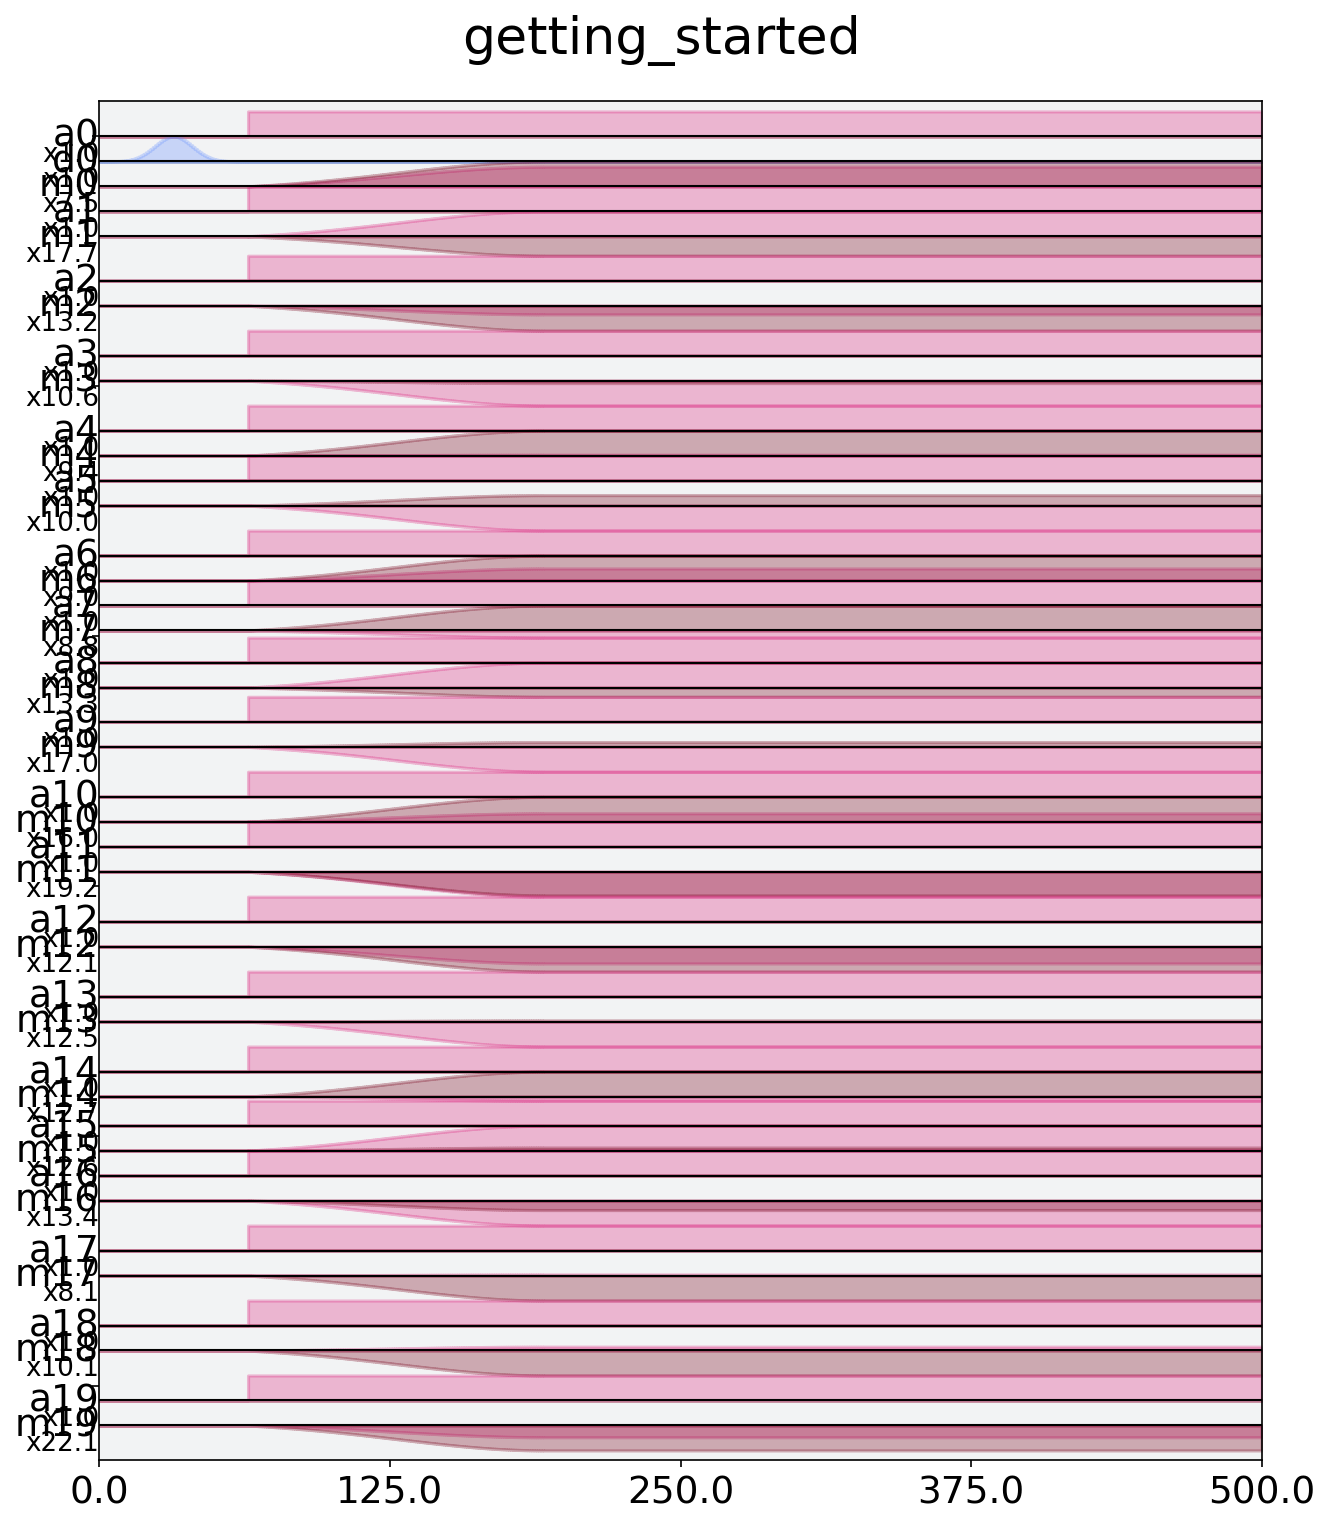

In [7]:
sched.draw(plot_range=[0, 500])

There is a new pulse on `MeasureChannel` `m0`, a shorthand name for `MeasureChannel(0)`. This channel stimulates readout on qubit 0. Likewise, `a0` is shorthand for `AcquireChannel(0)`. The `Acquire` instruction on `a0` tells the measurement devices when to begin collecting data on their analog-to-digital converters (ADC), and for how long. It is drawn as an amplitude 1 constant pulse.

### Execute

Our schedule is done! We can't use our mocked backend to execute programs, but if you have an IBM Quantum account, you could use `backend = IBMQ.load_account().get_backend(open_pulse=True)` to see if you have an OpenPulse enabled backend. Once you have such a backend, we can execute it the same way we execute circuits:

```
job = execute(sched, backend)
```
That's it! To get the results, use `result = job.result()`. You've created a Pulse program schedule, containing an operation on qubit 0 followed by a measurement, executed the experiment on the backend and retrieved the results.
Next, we will cover in detail the [different instructions which can be used in Pulse programs](2_building_pulse_instructions.ipynb).

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright